# Digit Recognition with Deep Learning

## Introduction

This is a contribution to the Kaggle Digit Recognizer competition: AstroDave, Will Cukierski. (2012). Digit Recognizer. Kaggle. https://kaggle.com/competitions/digit-recognizer.

In the realm of computer vision and machine learning, digit recognition serves as a fundamental problem with diverse applications ranging from automated postal code sorting to OCR (Optical Character Recognition). This notebook explores the creation of a digit recognition model using deep learning techniques.

Traditionally, convolutional neural networks (CNNs) have been the go-to architecture for image-related tasks, including digit recognition. However, this project takes a different approach by utilizing a deep learning model without CNNs. Instead, we use the provided input vector of black and white pixels, exploring the capacity of the model to discern patterns and features inherent in the pixel representations.

The objective is to develop an efficient and accurate digit recognition system that can generalize well to unseen data. Throughout the notebook, we will walk through data preprocessing, model architecture design, training, and evaluation processes. Additionally, we will incorporate best practices in hyperparameter tuning and regularization to enhance the model's robustness.

By the end of this exploration, we aim to have a well-optimized and interpretable digit recognition model, shedding light on the inner workings of deep learning when applied to image classification tasks without the conventional use of CNNs.

Let's embark on this journey of digit recognition through deep learning, delving into the intricacies of pixel-based input representations and uncovering insights into the model's decision-making processes.




In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
# Training and Testing dataframes are created
df_train_digits = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test_digits = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
df_train_digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Inspection and Exploration

### Checking for Missing Values

Before starting the model development, it is essential to ensure the integrity of our dataset. Here, we check for any missing values and find that there are none.

In [5]:
print('Number of missing values in the data set: ',df_train_digits.isna().sum().sum())

Number of missing values in the data set:  0


### Illustrating the Distribution of Digits

Understanding the distribution of digits in our dataset provides valuable insights into potential class imbalances. We visualize the label distribution as a bar plot and find that the data is mostly balanced between the different classes and we have roughly 4000 images for each digit.

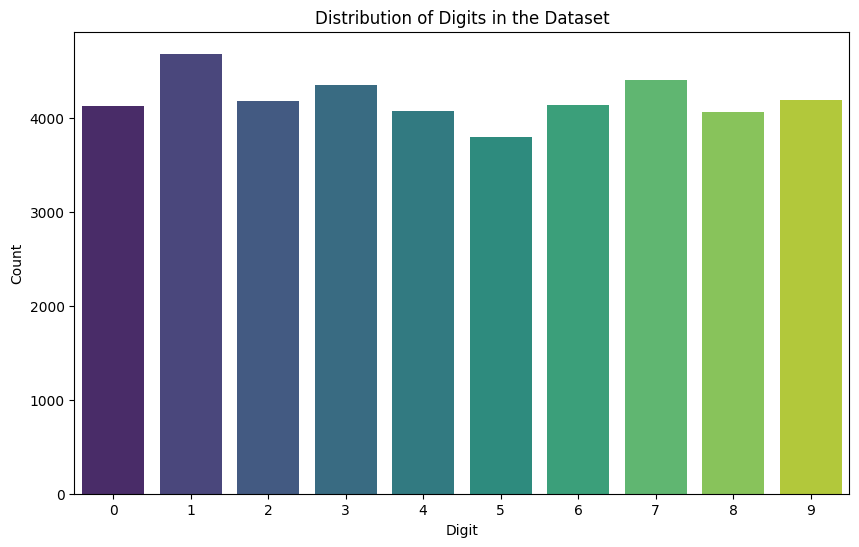

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the digit labels are in a column named 'label'
digit_distribution = df_train_digits['label'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=digit_distribution.index, y=digit_distribution.values, palette="viridis")
plt.title("Distribution of Digits in the Dataset")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

## Digit Illustration: Visualizing Pixel Representations

To gain deeper insights into our digit recognition dataset, we present visual representations of digits. 
The visualizations below display pixel representations of the selected digits, allowing us to observe the inherent variations and similarities. This step is crucial for understanding the challenges our model may face, especially when distinguishing between digits that share visual similarities.
By presenting digit triplets, we aim to highlight nuances in pixel patterns that contribute to the complexity of digit recognition.



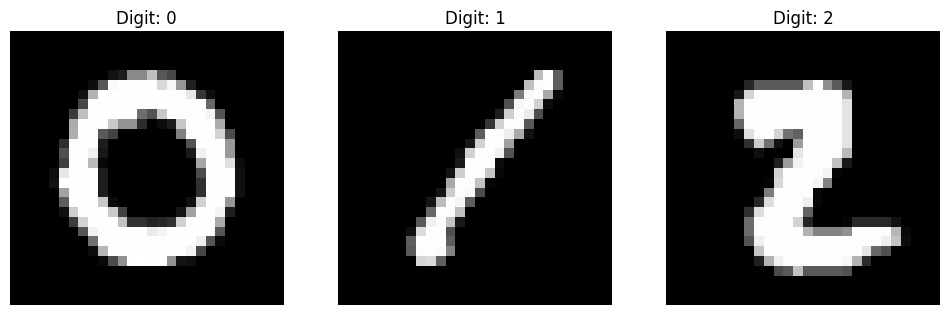

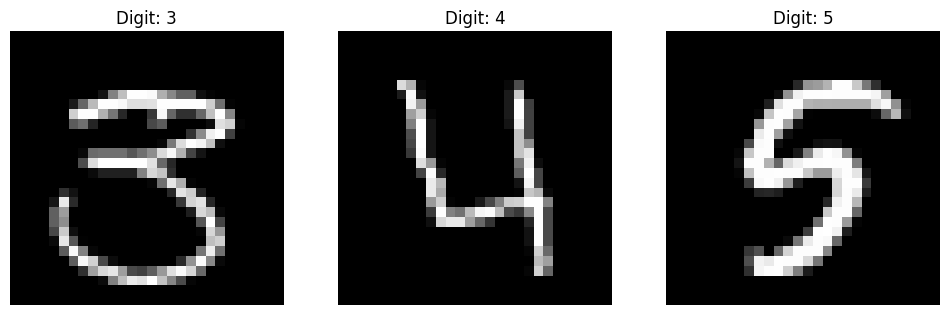

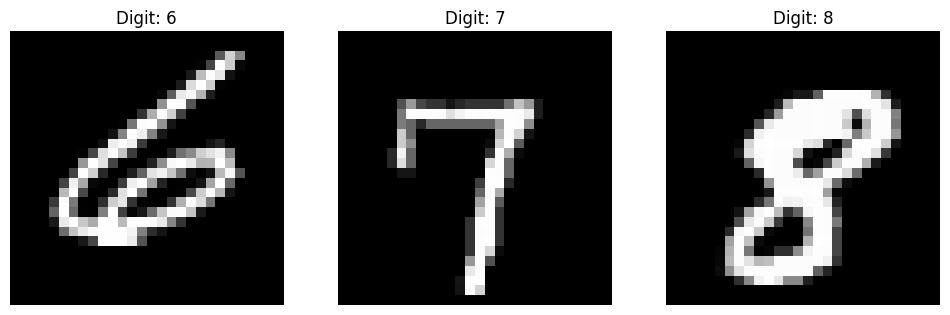

In [7]:
# Function to show three digits in a row
def show_three_digits_in_row(pixel_values1, label1, pixel_values2, label2, pixel_values3, label3):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Display the first digit
    axes[0].imshow(np.array(pixel_values1).reshape(28, 28), cmap='gray')
    axes[0].set_title(f"Digit: {label1}")
    axes[0].axis('off')

    # Display the second digit
    axes[1].imshow(np.array(pixel_values2).reshape(28, 28), cmap='gray')
    axes[1].set_title(f"Digit: {label2}")
    axes[1].axis('off')

    # Display the third digit
    axes[2].imshow(np.array(pixel_values3).reshape(28, 28), cmap='gray')
    axes[2].set_title(f"Digit: {label3}")
    axes[2].axis('off')

    plt.show()

# Display three digits in a row for each triplet (0, 1, and 2; 2, 3, and 4; etc.), excluding 9
for digit in range(0, 9, 3):  # Start from 0, increment by 3, exclude 9
    digit_data_1 = df_train_digits[df_train_digits['label'] == digit].iloc[0]
    digit_data_2 = df_train_digits[df_train_digits['label'] == digit + 1].iloc[0]
    digit_data_3 = df_train_digits[df_train_digits['label'] == digit + 2].iloc[0]

    pixel_values1, label1 = digit_data_1.drop('label').values, digit_data_1['label']
    pixel_values2, label2 = digit_data_2.drop('label').values, digit_data_2['label']
    pixel_values3, label3 = digit_data_3.drop('label').values, digit_data_3['label']

    show_three_digits_in_row(pixel_values1, label1, pixel_values2, label2, pixel_values3, label3)



## Principal Component Analysis (PCA)

The next step is exploring the data set through Principal Component Analysis (PCA). 

#### **Observations:**

In the scatter plot of principal components, each digit forms its own cloud of values, contributing to the overall complexity of digit representation. Notably, digits 0 and 1 exhibit distinct and well-separated clouds, indicating clear and easily distinguishable features. This aligns with our expectations, given the simple forms of these digits as a line and circle that are the most easily distinguishable among the digits.

#### **Implications:**

1. **Distinguishable Features of 0 and 1:**
   - The unique and separate clouds formed by digits 0 and 1 highlight their simplicity and straightforward spatial representations. This distinctiveness bodes well for the effectiveness of our model in discerning between these digits.
   
2. **Overlapping Digit Clouds:**
   - Digits 2 through 9 showcase varying degrees of overlap, suggesting shared spatial characteristics and challenges in their discrimination. The clustering of digit clouds reflects the intricacies of distinguishing between these numerals based on spatial arrangements of binary pixels. For instance, the digits 4, 7 and 9 (or 6 and 8) are harder to distinguish and their clouds mostly overlap. 

#### **Interpretation:**

- **Spatial Complexity Across Digits:**
  - The spatial complexity observed across digit clouds underscores the need for a model capable of capturing intricate spatial relationships for accurate digit recognition.

- **Model Considerations:**
  - While digits 0 and 1 present clear features, the challenge lies in developing a model that can navigate the overlapping digit clouds of 2 through 9. Model adaptations and feature engineering strategies should address this complexity for robust performance.

This PCA analysis serves as a valuable guide, emphasizing the varying degrees of overlap between digit clouds and the distinctive features exhibited by certain digits.



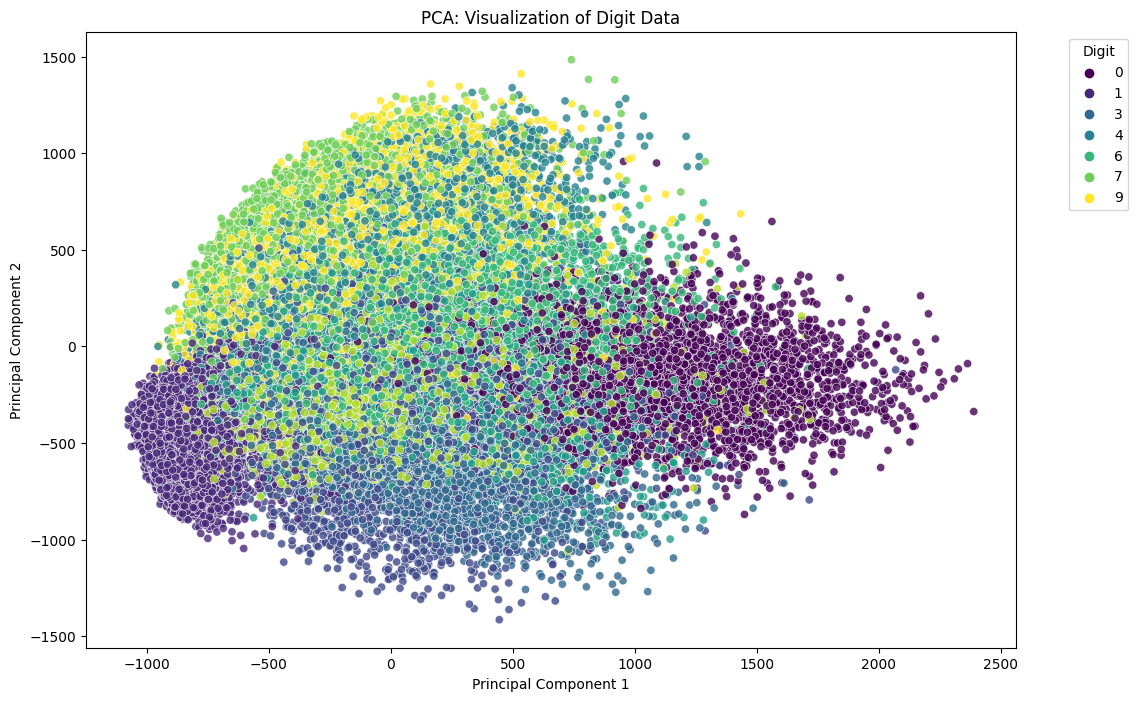

In [8]:
from sklearn.decomposition import PCA

# Extract pixel values
pixel_columns = df_train_digits.columns[df_train_digits.columns.str.startswith('pixel')]
pixel_data = df_train_digits[pixel_columns]

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pixel_data)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
final_df = pd.concat([principal_df, df_train_digits['label']], axis=1)

# Set the hue_order to ensure all digits are represented in the legend
hue_order = sorted(df_train_digits['label'].unique())

# Plot the PCA results with manual hue_order
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='label', hue_order=hue_order, data=final_df, palette='viridis', alpha=0.8)
plt.title('PCA: Visualization of Digit Data')

# Manually adjust the legend outside Seaborn
scatter.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




## Data Splitting: Training and Testing Sets

To assess our model's performance and ensure its generalization ability, we split our dataset into two subsets:

1. **Training Set:**
   - Used to train the neural network, the majority of the data teaches the model patterns and features.

2. **Validation Set:**
   - Kept separate for evaluation, this unseen dataset assesses the model's ability to generalize to new, unseen data.

### Benefits:

- **Performance Evaluation:**
  - Assesses the model's accuracy on new, real-world data.

- **Preventing Overfitting:**
  - Guards against overfitting by ensuring consistent performance across training and validation sets.

### Implementation:

We use `train_test_split` from scikit-learn to randomly divide the dataset.


In [9]:
# Split data into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train_digits.drop('label',axis=1), df_train_digits['label'], test_size=0.33, random_state=42)

In [10]:
# Check the input size 
input_shape = X_train.iloc[0].shape

# Model Description

## Model Architecture:

Our deep learning model is designed for digit recognition using TensorFlow and Keras. Here's an overview of the architecture:

1. **Input Layer:**
The input layer assumes each image is represented as a flattened 1D array of pixel values. The shape is determined by the input_shape parameter.
2. **Hidden Layers:**
The model includes two hidden layers with 128 and 64 units, respectively, using the ReLU activation function. These layers capture hierarchical features in the data.
To enhance generalization and prevent overfitting, dropout layers with a rate of 0.3 are inserted after each hidden layer. Additionally, batch normalization is applied to standardize and stabilize the input to each layer.
3. **Output Layer:**
The output layer consists of 10 units, corresponding to the possible digits (assuming 10 classes for digits 0-9). It uses the softmax activation function for multiclass classification.
4. **Compilation:**
The model is compiled with the Adam optimizer, sparse categorical crossentropy loss (since labels are integers), and accuracy as the evaluation metric.
5. **Early Stopping:**
To prevent overfitting and speed up training, an early stopping callback is implemented. Training stops if the validation loss does not improve for a specified number of epochs (patience).

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Assume your data is stored in X_train and y_train (features and labels)
# X_train should be a 2D array where each row represents a flattened image of pixels

# Define the model
model = models.Sequential([
    # Input layer (assuming each image is a 1D array of pixel values)
    layers.InputLayer(input_shape=input_shape),

    # Hidden layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Add another hidden layer if needed
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Output layer with 10 units (assuming 10 digits) and softmax activation for multiclass classification
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if labels are one-hot encoded
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Stop training when the validation loss doesn't improve
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Fit the model to the training data
model.fit(X_train, y_train, validation_data = [X_val,y_val],epochs=100, batch_size=32,callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

## Model illustration

Here, we see some further illustration of the model

In [20]:
!pip install pydot
!pip install pydot_ng
!pip install graphviz
!pip install plot_model

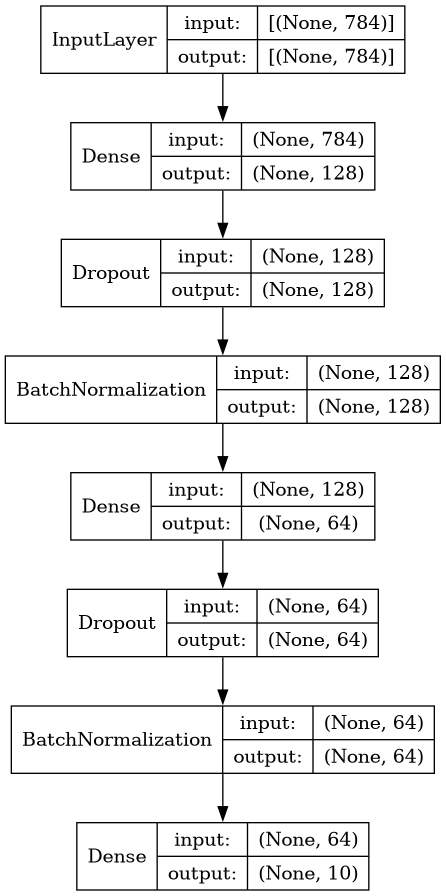

In [23]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture with custom styling
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True, dpi=96)#, layer_colors=layer_colors)

## Misclassification Analysis and Illustration

Understanding the misclassification patterns of our model provides valuable insights into its strengths and weaknesses. Misclassification analysis involves examining instances where the model predicts the wrong class and identifying potential patterns or challenges.

1. **Methodology:**
Identification of Misclassified Samples:
After training the model, predictions are made on the validation set, and misclassified samples are identified by comparing predicted labels with true labels.
2. **Visualization of Misclassified Images:**
A selection of misclassified images is visualized to gain a qualitative understanding of the types of errors the model makes. This visualization helps identify common patterns or challenges in misclassification.
3. **Distribution of Misclassified Numbers:**
The distribution of misclassified numbers is plotted to highlight which digits are more prone to misclassification. This analysis can guide further investigation into specific digits that might pose challenges for the model.
4. **Heatmap for Digit Misclassification Patterns:**
To delve deeper into the misclassification patterns, creating a heatmap is an insightful approach. The heatmap visually represents the confusion matrix, showcasing how often each true digit is misclassified as another digit. Rows correspond to true labels, while columns represent predicted labels. Lighter regions on the heatmap indicate higher frequencies of misclassification between specific digit pairs. Analyzing this heatmap allows us to pinpoint which digits tend to be confused with each other, providing valuable information for model refinement.

As suggested by the PCA, distinguishing between 4 and 9 respectively 7 and 9 is hard for the model. Further pairs that are hard to distinguish in this data set are 3 and 5 as well as 3 and 8. Looking at the form of the digits, we see that each of them share similar characteristics such as the form.

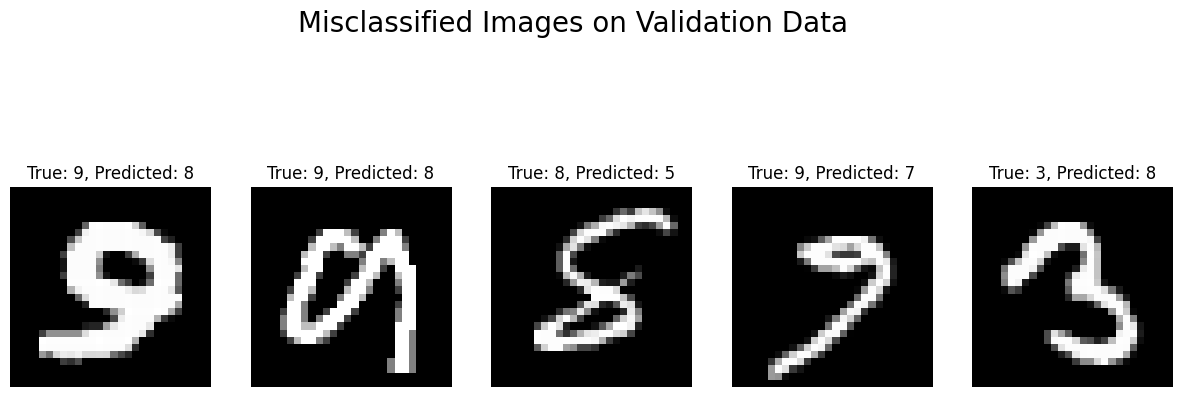

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained model named 'model' and validation data named 'X_val' and 'y_val'

# Step 1: Make predictions on the validation data
predictions = model.predict(X_val)

# Step 2: Identify misclassified samples
misclassified_indices = np.argmax(predictions, axis=1) != y_val
misclassified_images = X_val[misclassified_indices]
true_labels = y_val[misclassified_indices]
predicted_labels = np.argmax(predictions[misclassified_indices], axis=1)
# Step 3: Visualize misclassified images with increased space between subplots
num_samples_to_visualize = 5

# Adjusting spacing between subplots
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(15, 5), gridspec_kw={'hspace': 0.5})

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(num_samples_to_visualize):
    axes[i].imshow(misclassified_images.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {true_labels.iloc[i]}, Predicted: {predicted_labels[i]}')
    axes[i].axis('off')

plt.suptitle('Misclassified Images on Validation Data', y=1.05,fontsize=20)
plt.show()


Misclassification Analysis:
True Label 9: {8: 20, 7: 17, 3: 13, 0: 9, 4: 17, 5: 1, 1: 2, 6: 1}
True Label 8: {5: 6, 1: 8, 0: 1, 3: 10, 4: 7, 7: 2, 2: 3, 6: 3, 9: 4}
True Label 3: {8: 33, 7: 22, 9: 9, 5: 18, 2: 12, 6: 2, 1: 4, 0: 3, 4: 1}
True Label 7: {4: 13, 9: 33, 0: 4, 3: 2, 2: 5, 1: 7, 5: 2}
True Label 5: {9: 10, 3: 42, 8: 23, 0: 7, 4: 8, 6: 13, 1: 3, 2: 1, 7: 2}
True Label 2: {8: 18, 0: 13, 7: 8, 1: 6, 4: 15, 6: 6, 3: 4, 5: 1, 9: 1}
True Label 0: {6: 3, 8: 4, 3: 1, 5: 4, 4: 4, 9: 1}
True Label 1: {7: 8, 8: 4, 2: 4, 6: 3, 4: 1, 9: 1, 3: 4}
True Label 6: {5: 9, 1: 3, 0: 18, 8: 5, 4: 8, 2: 1}
True Label 4: {9: 39, 6: 6, 2: 3, 0: 4, 5: 1}


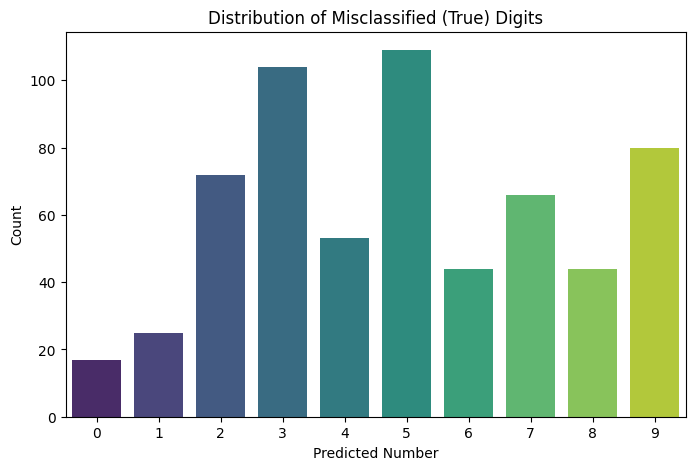

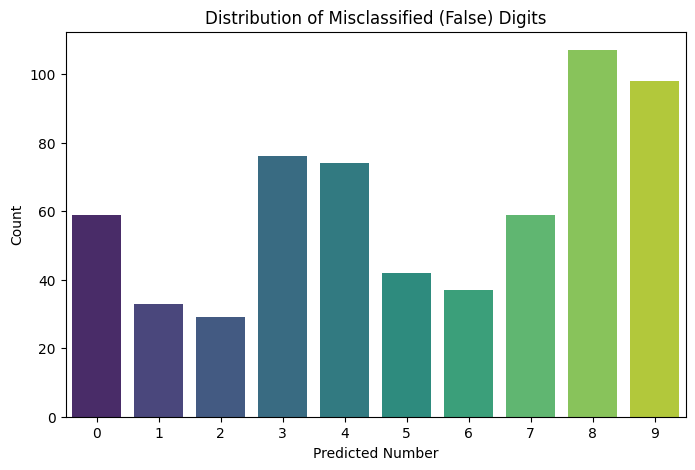

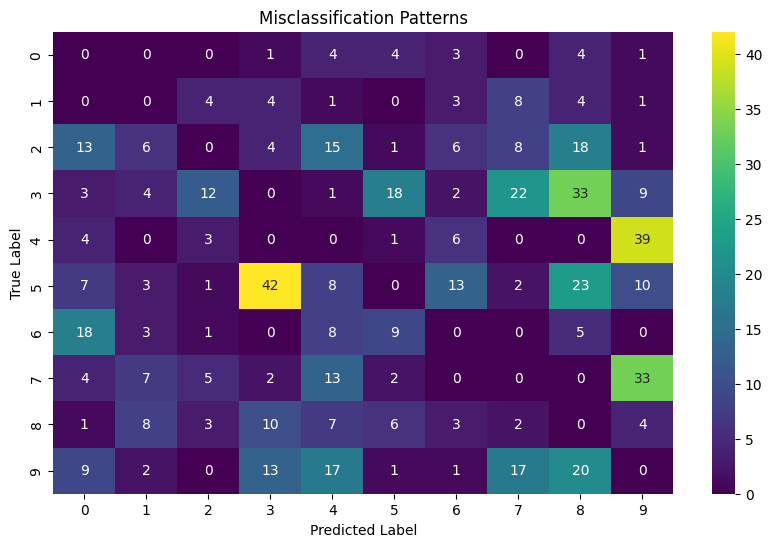

In [85]:
# Step 4: Analyze misclassification patterns
misclassification_analysis = {}
for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label not in misclassification_analysis:
        misclassification_analysis[true_label] = {predicted_label: 1}
    else:
        if predicted_label not in misclassification_analysis[true_label]:
            misclassification_analysis[true_label][predicted_label] = 1
        else:
            misclassification_analysis[true_label][predicted_label] += 1
            
# Print misclassification analysis
print("Misclassification Analysis:")
for true_label, predictions in misclassification_analysis.items():
    print(f"True Label {true_label}: {predictions}")

# Visualize misclassification patterns
fig, ax = plt.subplots(figsize=(10, 6))
heatmap_data = np.zeros((10, 10))
for true_label, predictions in misclassification_analysis.items():
    for predicted_label, count in predictions.items():
        heatmap_data[true_label, predicted_label] = count

sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis', cbar=True, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Misclassification Patterns')
plt.show()


# Distribution of digits that are wrongly labeled
plt.figure(figsize=(8, 5))
sns.countplot(x=true_labels, palette='viridis')
plt.title('Distribution of Misclassified (True) Digits')
plt.xlabel('Predicted Number')
plt.ylabel('Count')
plt.show()

# Distribution of digits that are wrongly labeled
plt.figure(figsize=(8, 5))
sns.countplot(x=predicted_labels, palette='viridis')
plt.title('Distribution of Misclassified (False) Digits')
plt.xlabel('Predicted Number')
plt.ylabel('Count')
plt.show()

# Test Predictions

After training the model and fine-tuning its performance, it's time to make predictions on the test dataset and prepare the results for submission. The process involves utilizing the trained model to predict the labels of the test data. The predictions are then organized into a DataFrame, which is a structured tabular data format. Each row in the DataFrame corresponds to an image in the test set, and the columns represent the predicted probability scores for each digit class (0-9). This DataFrame is crucial for generating a submission file that can be uploaded to the competition platform. 

In [ ]:
# Make predictions on the test data
predictions = model.predict(df_test_digits)
# If you are doing classification and want the predicted class labels
predicted_labels = predictions.argmax(axis=1)

# Create a submission dataframe
submission_df = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission_df['Label'] = predicted_labels.squeeze()
submission_df.to_csv('submission.csv', index=False)

print(f"Predictions saved to DataFrame")

# Future Work - Other Deep Learning Models:
While this model gives us a decent accuracy, there is still a lot of room for improvement. Future work can use some of the following ideas:

1. **Convolutional Neural Network (CNN):**
Well-suited for image data, CNNs can capture spatial hierarchies and are robust to variations in position and scale.
2. **Recurrent Neural Network (RNN):**
Effective for sequential data, RNNs can be useful if there is temporal information or dependencies between pixels.
3. **Transfer Learning (e.g., using pre-trained models like ResNet or VGG):**
Leveraging pre-trained models on large image datasets can boost performance, especially with limited labeled data.
4. **Ensemble Models:**
Combining multiple models (e.g., stacking or bagging) can enhance overall predictive performance.